In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, SimpleRNN, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from keras.layers import Input
from sklearn.metrics import mean_absolute_percentage_error

In [27]:
def train_eval(dataset_path, selected_model='lstm', epochs=20, verbose=0):
    # Load data
    df = pd.read_csv(dataset_path, parse_dates=['Datetime'], index_col='Datetime')
    
    # We’ll forecast 'Global_active_power'
    data = df['Global_active_power'].values

    # Normalize the data using MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data.reshape(-1, 1))

    # Prepare data for supervised learning (X, y)
    def create_dataset(data, time_step=1):
        X, y = [], []
        for i in range(len(data) - time_step - 1):
            X.append(data[i:(i + time_step), 0])
            y.append(data[i + time_step, 0])
        return np.array(X), np.array(y)

    time_step = 60  # number of time steps for each input sequence
    X, y = create_dataset(data_scaled, time_step)
    X = X.reshape(X.shape[0], X.shape[1], 1)

    # Split the dataset into train and test sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Build LSTM Model
    def build_lstm_model():
        model = Sequential()
        model.add(Input(shape=(X_train.shape[1], 1)))  # Use Input() instead of specifying input_shape
        model.add(LSTM(50, return_sequences=True))
        model.add(LSTM(50, return_sequences=False))
        model.add(Dense(1))
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
        return model

    # Build GRU Model
    def build_gru_model():
        model = Sequential()
        model.add(Input(shape=(X_train.shape[1], 1)))  # Use Input() instead of specifying input_shape
        model.add(GRU(50, return_sequences=True))
        model.add(GRU(50, return_sequences=False))
        model.add(Dense(1))
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
        return model

    # Build RNN Model
    def build_rnn_model():
        model = Sequential()
        model.add(Input(shape=(X_train.shape[1], 1)))  # Use Input() instead of specifying input_shape
        model.add(SimpleRNN(50, return_sequences=True))
        model.add(SimpleRNN(50, return_sequences=False))
        model.add(Dense(1))
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
        return model

    # Build ConvLSTM Model
    def build_convlstm_model():
        model = Sequential()
        model.add(Input(shape=(X_train.shape[1], 1)))  # Use Input() instead of specifying input_shape
        model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(LSTM(50))
        model.add(Dense(1))
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
        return model


    # Choose the model
    if selected_model == "gru":
        model = build_gru_model()
    elif selected_model == "rnn":
        model = build_rnn_model()
    elif selected_model == "lstm":
        model = build_lstm_model()
    elif selected_model == "convlstm":
        model = build_convlstm_model()
    else:
        raise ValueError("Selected model must be one of 'lstm', 'gru', 'rnn', or 'convlstm'.")

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=64, verbose=verbose)

    # --- Revised Rolling Forecasting ---
    # Instead of storing arrays of shape (time_step, 1) in history, we store a flat list of values.
    # We'll initialize history with the initial segment of the series that was used to create X.
    # Note: Our supervised dataset was created from data_scaled[0 : len(data_scaled)-time_step-1].
    # We can initialize history with data_scaled[0:train_size + time_step] flattened.
    history = list(data_scaled[:train_size + time_step].flatten())

    predictions = []
    # The number of forecasts equals the number of test samples (which is len(X_test))
    for i in range(len(X_test)):
        # Get the last 'time_step' values from history and reshape for prediction.
        current_input = np.array(history[-time_step:]).reshape(1, time_step, 1)
        pred = model.predict(current_input, verbose=0)
        predictions.append(pred[0, 0])
        # Update history with the actual next value from the test set.
        # y_test contains the actual target values (normalized).
        history.append(y_test[i])
    # --- End Revised Rolling Forecasting ---

    # Invert scaling for actual and predicted values
    y_test_rescaled = scaler.inverse_transform(np.array(y_test).reshape(-1, 1))
    predictions_rescaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

    # Plot forecasted vs actual values
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_rescaled, label='Actual')
    plt.plot(predictions_rescaled, label='Predicted')
    plt.title('Forecasted vs Actual Global Active Power')
    plt.xlabel('Time')
    plt.ylabel('Global Active Power (kW)')
    plt.legend()
    plt.show()

    # Evaluation Metrics
    mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
    mape = mean_absolute_percentage_error(y_test_rescaled, predictions_rescaled)
    r2 = r2_score(y_test_rescaled, predictions_rescaled)

    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')
    print(f'MAPE: {mape}')
    print(f'R2: {r2}')

# Subset Dataset

In [28]:
dataset_path = './data/subset_dataset_resampled.csv'

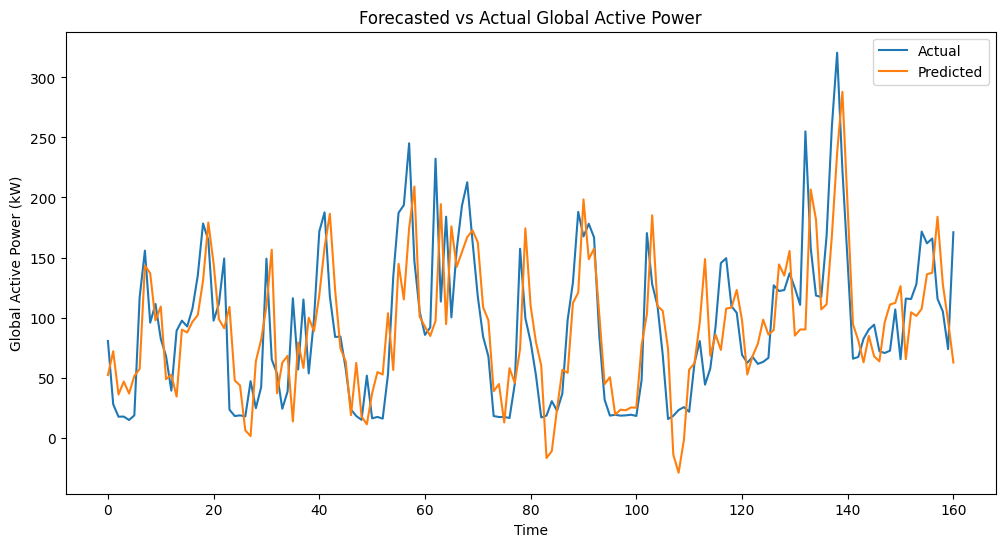

MSE: 2034.2167476356385
RMSE: 45.10229204414825
MAE: 35.54885821645156
MAPE: 0.6020586588360272
R2: 0.46409779333314205


In [29]:
train_eval(dataset_path=dataset_path, selected_model='rnn', epochs=50)

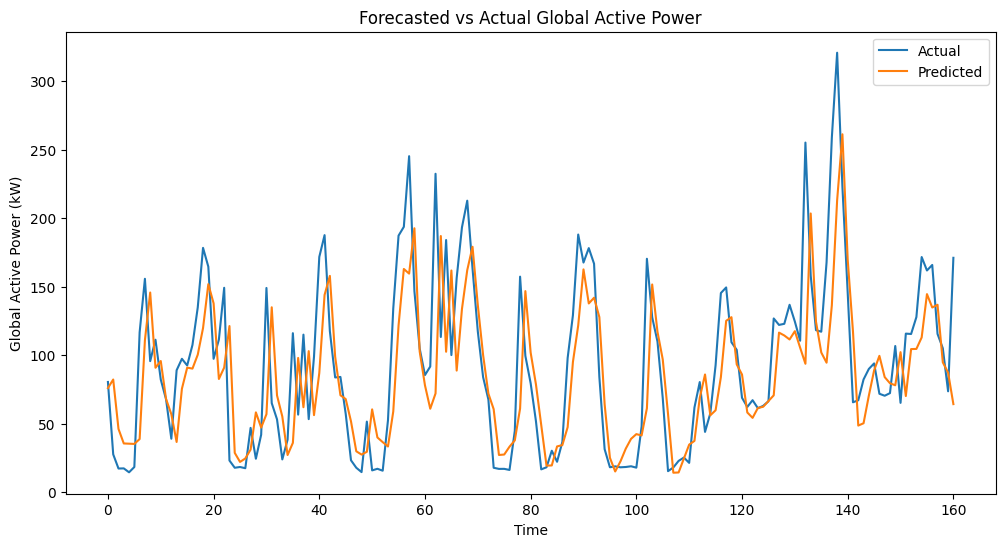

MSE: 1929.7221072083187
RMSE: 43.92860238168657
MAE: 32.25197375862643
MAPE: 0.4789738345891433
R2: 0.49162627988942864


In [30]:
train_eval(dataset_path=dataset_path, selected_model='gru', epochs=50)

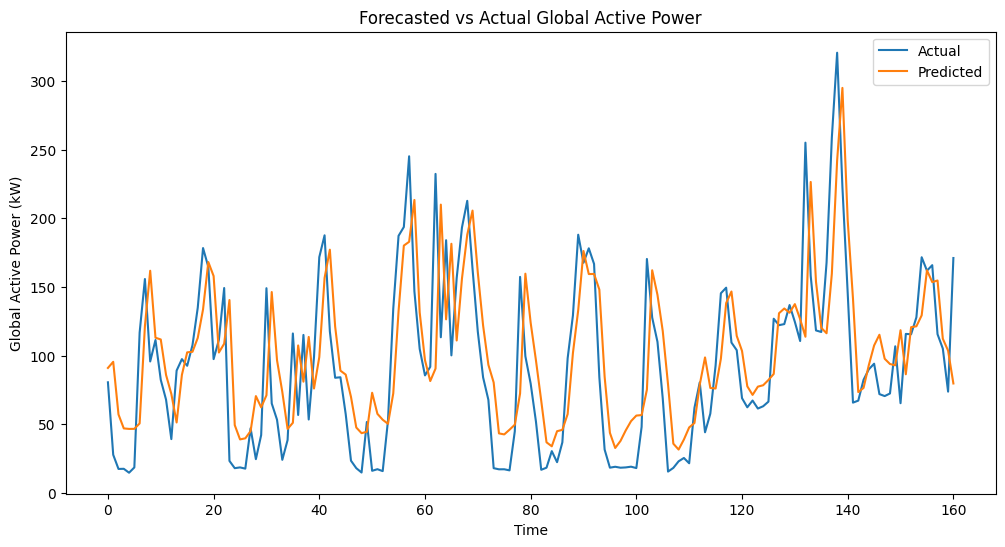

MSE: 1968.7867224870654
RMSE: 44.371012186866615
MAE: 35.27278761092476
MAPE: 0.6769037846852671
R2: 0.48133494119368514


In [31]:
train_eval(dataset_path=dataset_path, selected_model='lstm', epochs=50)

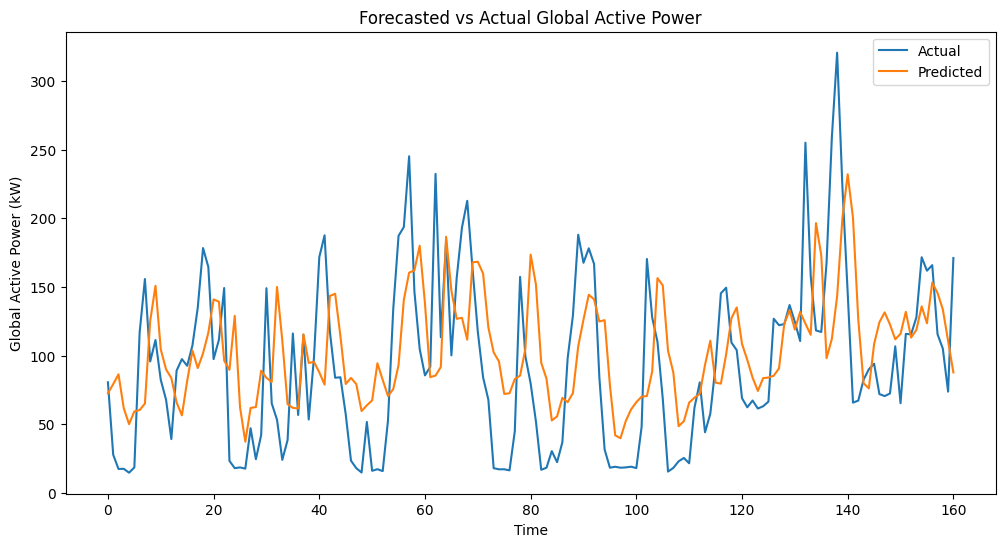

MSE: 3211.7113516628865
RMSE: 56.67196265935111
MAE: 46.59550549126856
MAPE: 0.9957857612141161
R2: 0.15389389919553143


In [32]:
train_eval(dataset_path=dataset_path, selected_model='convlstm', epochs=50)

# Complete Dataset

In [33]:
dataset_path = './data/dataset_resampled.csv'

Epoch 1/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0189
Epoch 2/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0092
Epoch 3/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0089
Epoch 4/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0086
Epoch 5/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0085
Epoch 6/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0085
Epoch 7/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0085
Epoch 8/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0084
Epoch 9/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0082
Epoch 10/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0084
Epoch 11/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0084
Epoch 12/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0084
Epoch 13/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0083
Epoch 14/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0083
Epoch 15/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 5s

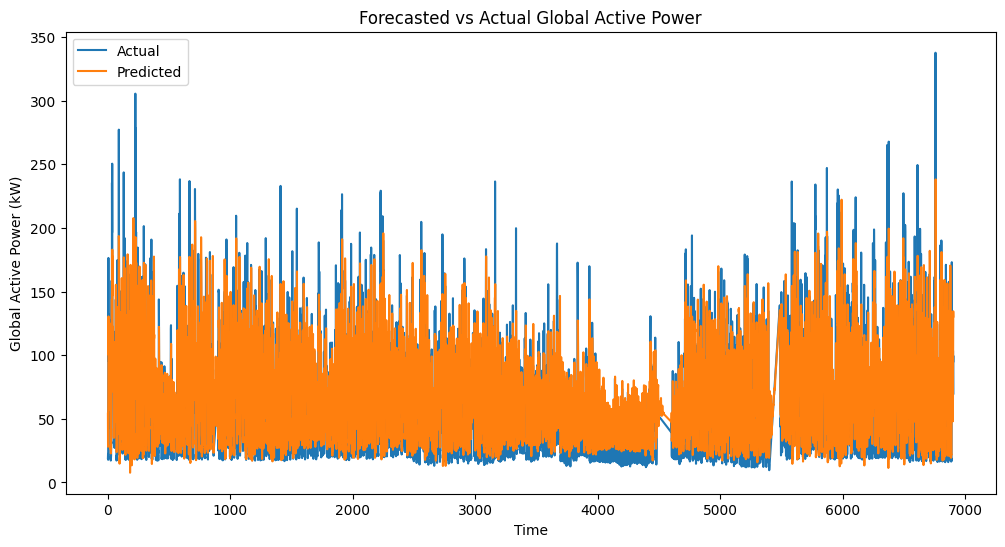

MSE: 948.7045834604671
RMSE: 30.801048414956057
MAE: 22.318895914918265
MAPE: 0.5529728479245006
R2: 0.5033050252002291


In [34]:
train_eval(dataset_path=dataset_path, selected_model='rnn', epochs=50, verbose=1)

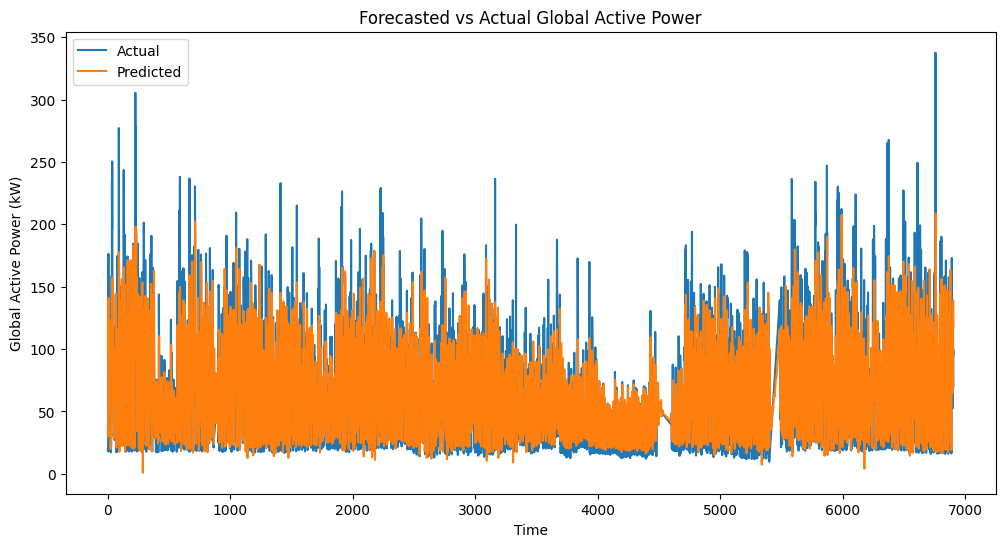

MSE: 867.4101031342483
RMSE: 29.45182682168032
MAE: 20.630407581016858
MAPE: 0.45901672049365444
R2: 0.5458668095121675


In [35]:
train_eval(dataset_path=dataset_path, selected_model='gru', epochs=50)

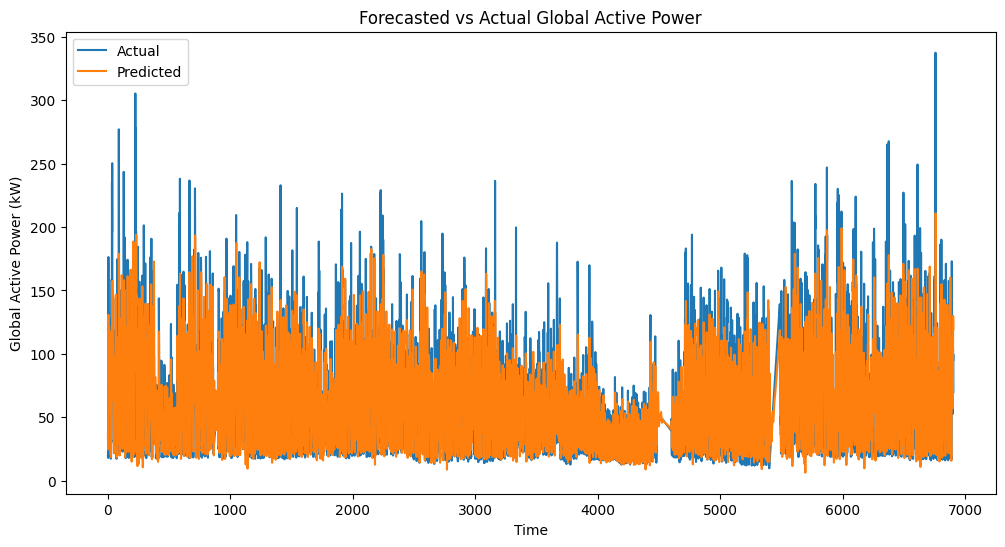

MSE: 869.082877563797
RMSE: 29.4802116268489
MAE: 20.04871624714701
MAPE: 0.4115466801318652
R2: 0.5449910272427283


In [36]:
train_eval(dataset_path=dataset_path, selected_model='lstm', epochs=50)

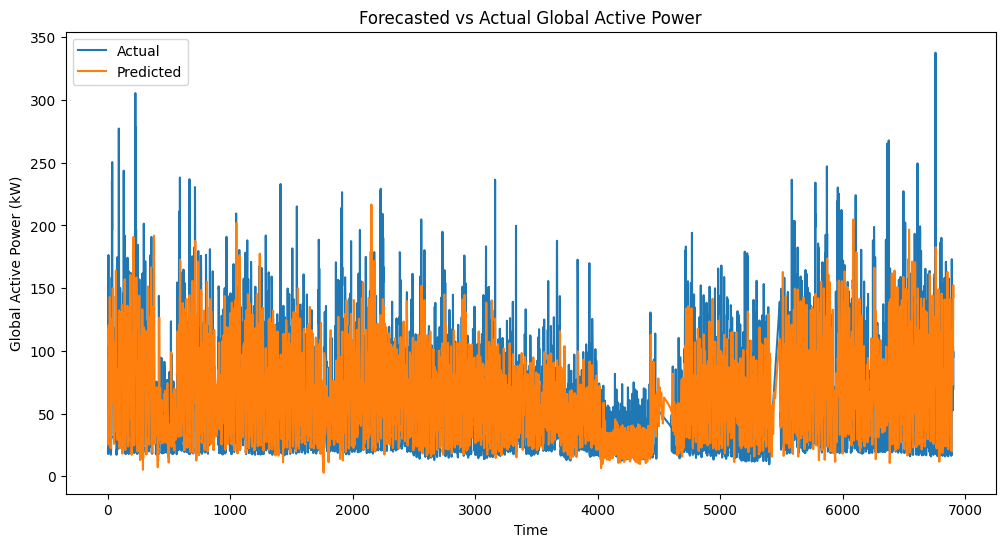

MSE: 1270.8524312717182
RMSE: 35.64901725534265
MAE: 25.73988022159564
MAPE: 0.5982152794784873
R2: 0.33464428513427014


In [37]:
train_eval(dataset_path=dataset_path, selected_model='convlstm', epochs=50)